In [10]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import time

from implementations import *
from auxfunctions import *

import warnings
warnings.filterwarnings('ignore')

In [11]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X.reshape(-1), Y.reshape(-1))
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], 
             [min(min(X), min(Y)), max(max(X), max(Y))],
             ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

Parámetros

In [12]:
d = 2

n_1 = 2_000
n_2 = 3_000

sup = 20

# Parameters
nu_1 = 3/2
theta_1 = 1

nu_2 = 1/2
theta_2 = 1

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8660254037844387

In [13]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [14]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.25)

In [15]:
X_1.shape, X_test.shape

((1500, 2), (500, 2))

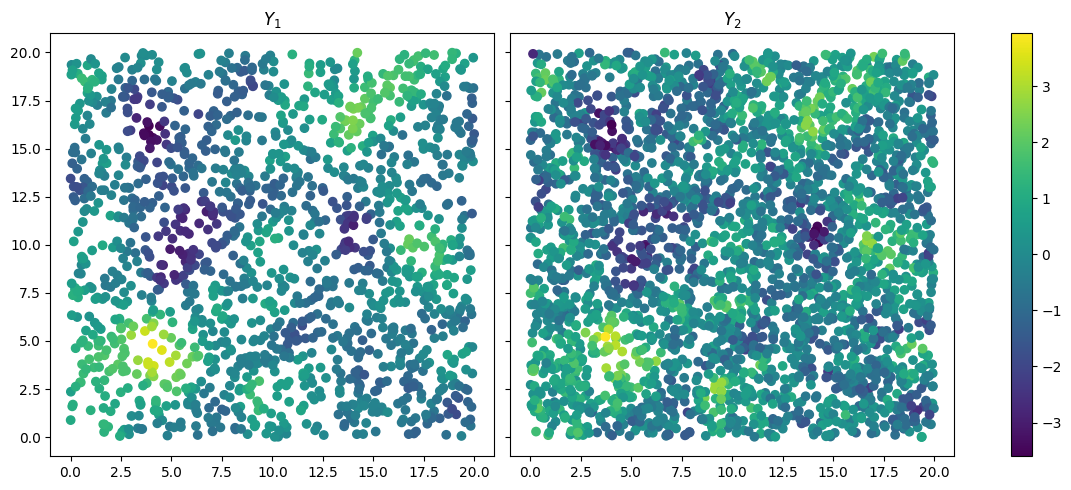

In [16]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

## Análisis `n_clusters`

In [22]:
times = []
rmses = []
iter_n_clusters = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512])
num_iterations = 10

for n_clusters in iter_n_clusters:
    execution_time = 0
    rmse = 0
    for _ in range(num_iterations):
        start_time = time.time()
        
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_NcoK = NcoK.predict(X_test, A_1, A_2)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_NcoK, Y_test)
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

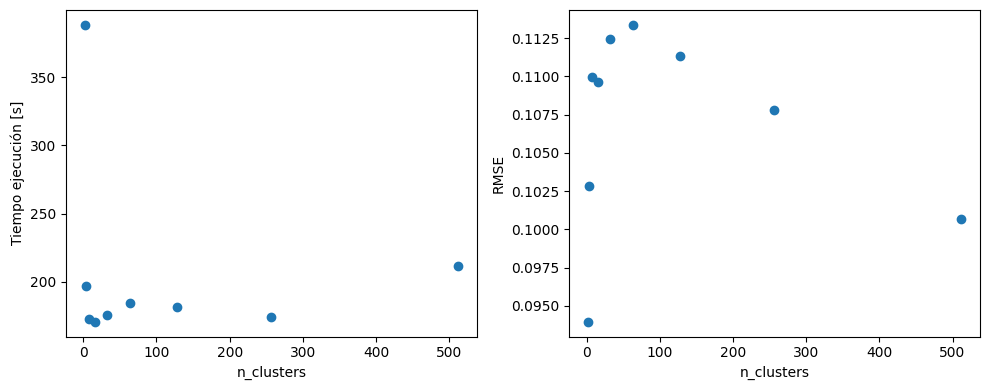

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(iter_n_clusters, times)
ax1.set_xlabel('n_clusters'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(iter_n_clusters, rmses)
ax2.set_xlabel('n_clusters'); ax2.set_ylabel('RMSE')

fig.tight_layout()

#OBS PROM POR CLUSTER = TOTAL_OBS / #CLUSTERS

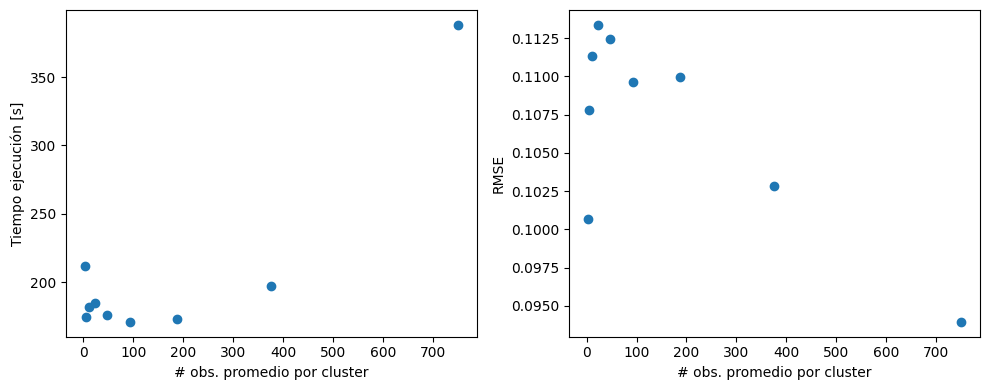

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(X_1.shape[0] / np.array(iter_n_clusters), times)
ax1.set_xlabel('# obs. promedio por cluster'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(X_1.shape[0] / np.array(iter_n_clusters), rmses)
ax2.set_xlabel('# obs. promedio por cluster'); ax2.set_ylabel('RMSE')

fig.tight_layout()

## Comparamos los 4 métodos

In [18]:
n_clusters = 500

In [19]:
start_time = time.time()

A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
Y_NcoK = NcoK.predict(X_test, A_1, A_2)

end_time = time.time()
time_NcoK = end_time - start_time

In [20]:
start_time = time.time()

sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))

end_time = time.time()
time_K = end_time - start_time

In [22]:
start_time = time.time()

sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

end_time = time.time()
time_coK = end_time - start_time

In [23]:
start_time = time.time()

NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
Y_NK = NK.predict(X_test, A_1)

end_time = time.time()
time_NK = end_time - start_time

In [24]:
RMSE_K = root_mean_squared_error(Y_K, Y_test)
RMSE_NK = root_mean_squared_error(Y_NK, Y_test)
RMSE_coK = root_mean_squared_error(Y_coK, Y_test)
RMSE_NcoK = root_mean_squared_error(Y_NcoK, Y_test)

In [25]:
RMSE_coK < RMSE_NcoK < RMSE_K < RMSE_NK

True

In [26]:
RMSE_coK, RMSE_NcoK, RMSE_K, RMSE_NK

(0.07516747362625627,
 0.08943636510313435,
 0.12224773903589221,
 0.12653105590674543)

PC2
```python
(0.08350944822827279,
 0.11008184275822966,
 0.12797912952594948,
 0.13968269645634235)
```

In [27]:
time_K < time_NK < time_coK < time_NcoK

True

In [28]:
time_K, time_NK, time_coK, time_NcoK

(0.47606992721557617,
 47.39938712120056,
 62.015700340270996,
 366.87043499946594)

PC2
```python
(30.979496955871582, 49.83596086502075, 145.76787114143372, 593.4517714977264)
```

## Análisis de RMSE vs $\rho_{12}$

In [23]:
# Parameters fixed
d = 2
n_1 = 300
n_2 = 300
sup = 20

nu_1 = 3/2
theta_1 = 1
nu_2 = 3/2
nu_12 = ( nu_1 + nu_2 ) / 2

In [24]:
rhos_12 = []
RMSEs_K = []
RMSEs_NK = []
RMSEs_coK = []
RMSEs_NcoK = []

thetas_2 = np.arange(0.05, 1.05, 0.05)
iter_n_clusters = [2, 50, 100]
num_iterations = 25

for theta_2 in thetas_2:
    theta_12 = min(theta_1, theta_2)
    rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
    rhos_12.append(rho_12)
    
    RMSE_K = 0
    RMSE_NK = np.zeros(len(iter_n_clusters))
    RMSE_coK = 0
    RMSE_NcoK = np.zeros(len(iter_n_clusters))
    
    for _ in range(num_iterations):
        X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)
        X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=1/3)

        # Kriging
        sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
        Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))
        RMSE_K += root_mean_squared_error(Y_K, Y_test)
          
        # CoKriging     
        sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
        Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, sigma)
        RMSE_coK += root_mean_squared_error(Y_coK, Y_test)

        for i, n_clusters in enumerate(iter_n_clusters):        
            # Nested CoKriging
            A_1 = gen_A(X_1, n_clusters)
            A_2 = gen_A(X_2, n_clusters)
            NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_NcoK = NcoK.predict(X_test, A_1, A_2)
            RMSE_NcoK[i] += root_mean_squared_error(Y_NcoK, Y_test)
            
            # Nested Kriging
            NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
            Y_NK = NK.predict(X_test, A_1)
            RMSE_NK[i] += root_mean_squared_error(Y_NK, Y_test)
            
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)
    RMSEs_K.append(RMSE_K / num_iterations)
    RMSEs_NK.append(RMSE_NK / num_iterations)
    RMSEs_coK.append(RMSE_coK / num_iterations)

RMSEs_NK = np.array(RMSEs_NK)
RMSEs_NcoK = np.array(RMSEs_NcoK)

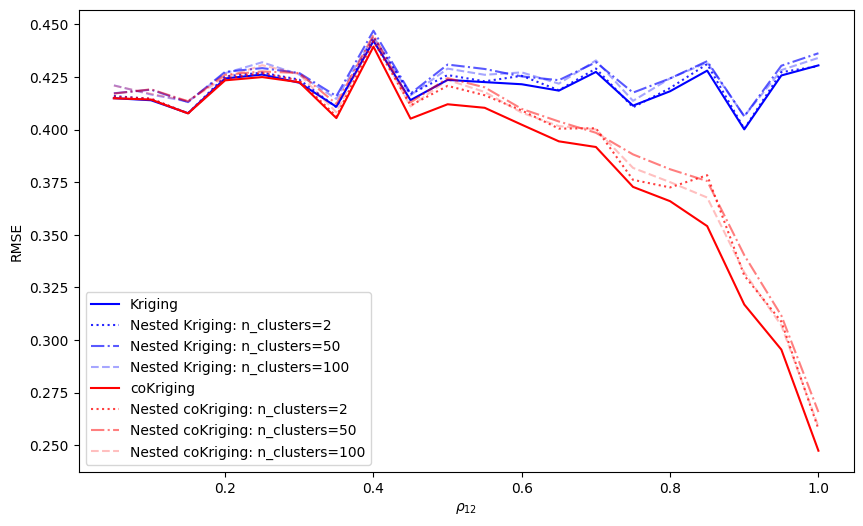

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(rhos_12, RMSEs_K, label='Kriging', c='b')
plt.plot(rhos_12, RMSEs_NK[:, 0], label=f'Nested Kriging: n_clusters={iter_n_clusters[0]}', ls=':', c='b', alpha=.85)
plt.plot(rhos_12, RMSEs_NK[:, 1], label=f'Nested Kriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='b', alpha=.65)
plt.plot(rhos_12, RMSEs_NK[:, 2], label=f'Nested Kriging: n_clusters={iter_n_clusters[2]}', ls='--', c='b', alpha=.35)
    
plt.plot(rhos_12, RMSEs_coK, label='coKriging', c='r')
plt.plot(rhos_12, RMSEs_NcoK[:, 0], label=f'Nested coKriging: n_clusters={iter_n_clusters[0]}', ls=':', c='r', alpha=.75)
plt.plot(rhos_12, RMSEs_NcoK[:, 1], label=f'Nested coKriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='r', alpha=.5)
plt.plot(rhos_12, RMSEs_NcoK[:, 2], label=f'Nested coKriging: n_clusters={iter_n_clusters[2]}', ls='--', c='r', alpha=.25)

plt.legend()
plt.xlabel(r'$\rho_{12}$'); plt.ylabel('RMSE');

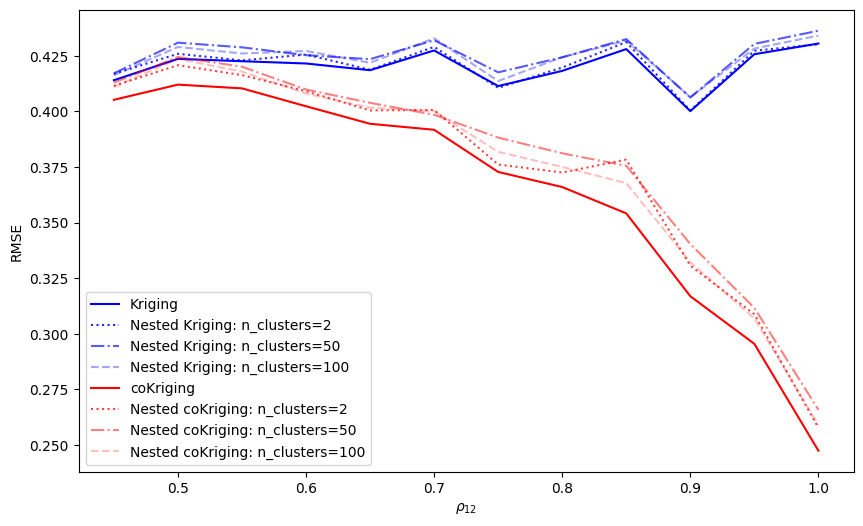

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(rhos_12[8:], RMSEs_K[8:], label='Kriging', c='b')
plt.plot(rhos_12[8:], RMSEs_NK[8:, 0], label=f'Nested Kriging: n_clusters={iter_n_clusters[0]}', ls=':', c='b', alpha=.85)
plt.plot(rhos_12[8:], RMSEs_NK[8:, 1], label=f'Nested Kriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='b', alpha=.65)
plt.plot(rhos_12[8:], RMSEs_NK[8:, 2], label=f'Nested Kriging: n_clusters={iter_n_clusters[2]}', ls='--', c='b', alpha=.35)
    
plt.plot(rhos_12[8:], RMSEs_coK[8:], label='coKriging', c='r')
plt.plot(rhos_12[8:], RMSEs_NcoK[8:, 0], label=f'Nested coKriging: n_clusters={iter_n_clusters[0]}', ls=':', c='r', alpha=.75)
plt.plot(rhos_12[8:], RMSEs_NcoK[8:, 1], label=f'Nested coKriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='r', alpha=.5)
plt.plot(rhos_12[8:], RMSEs_NcoK[8:, 2], label=f'Nested coKriging: n_clusters={iter_n_clusters[2]}', ls='--', c='r', alpha=.25)

plt.legend()
plt.xlabel(r'$\rho_{12}$'); plt.ylabel('RMSE');

In [26]:
df = pd.DataFrame()

df['rhos_12'] = rhos_12
df['RMSE_k'] = RMSEs_K
df[['RMSE_nk_2', 'RMSE_nk_50', 'RMSE_nk_100']] = RMSEs_NK
df['RMSE_cok'] = RMSEs_coK
df[['RMSE_ncok_2', 'RMSE_ncok_50', 'RMSE_ncok_100']] = RMSEs_NcoK

df

,rhos_12,RMSE_k,RMSE_nk_2,RMSE_nk_50,RMSE_nk_100,RMSE_cok,RMSE_ncok_2,RMSE_ncok_50,RMSE_ncok_100
0,0.05,0.414924,0.415953,0.417240,0.421019,0.414865,0.415620,0.417115,0.420925
1,0.10,0.413943,0.414550,0.418981,0.416667,0.414283,0.414727,0.419139,0.416957
2,0.15,0.407787,0.407682,0.413042,0.413289,0.407690,0.407684,0.413455,0.413662
3,0.20,0.424298,0.425292,0.427435,0.426811,0.423402,0.424251,0.426065,0.424789
4,0.25,0.426147,0.427047,0.429209,0.431992,0.424951,0.426814,0.427620,0.430584
5,0.30,0.422264,0.423727,0.426881,0.426157,0.422493,0.423351,0.426879,0.426337
6,0.35,0.410845,0.410619,0.415890,0.414554,0.405455,0.406329,0.412179,0.408225
7,0.40,0.442117,0.443813,0.446981,0.444201,0.439419,0.442027,0.444923,0.443471
8,0.45,0.413997,0.416880,0.417120,0.416269,0.405195,0.411474,0.412908,0.410990
9,0.50,0.423618,0.425906,0.430895,0.428961,0.412033,0.420781,0.424447,0.423613


In [30]:
df.to_csv(r'D:\Aleja\OneDrive - Universidad Técnica Federico Santa María\Material universidad\0 Tesís\rhos_12_vs_rmse_models.csv', index=False, sep=';')

# RMSE, Tiempo vs n_1, n_2

In [10]:
# Parameters fixed
d = 2
sup = 20

nu_1 = 3/2
theta_1 = 1
nu_2 = 1/2
theta_2 = 1
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8660254037844387

In [12]:
RMSEs_K = []
RMSEs_NK = []
RMSEs_coK = []
RMSEs_NcoK = []

times_K = []
times_NK = []
times_coK = []
times_NcoK = []

ns = np.arange(1_000, 8_001, 1_000)
num_iterations = 1

for n in ns:
    RMSE_K = 0
    RMSE_NK = np.zeros(3)
    RMSE_coK = 0
    RMSE_NcoK = np.zeros(3)

    time_K = 0
    time_NK = np.zeros(3)
    time_coK = 0
    time_NcoK = np.zeros(3)
    
    for _ in range(num_iterations):
        X_1, X_2, Y_1, Y_2 = gen_observations(d, n, n, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)
        X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=1/10)

        # Kriging
        start_time = time.time()
        sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
        Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))
        end_time = time.time()
        time_K += (end_time - start_time)
        RMSE_K += root_mean_squared_error(Y_K, Y_test)
          
        # CoKriging
        start_time = time.time()
        sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
        Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, sigma)
        end_time = time.time()
        time_coK += (end_time - start_time)
        RMSE_coK += root_mean_squared_error(Y_coK, Y_test)

        iter_n_clusters = [2, X_1.shape[0]//10, X_1.shape[0]//2]
        for i, n_clusters in enumerate(iter_n_clusters):        
            # Nested CoKriging
            start_time = time.time()
            A_1 = gen_A(X_1, n_clusters)
            A_2 = gen_A(X_2, n_clusters)
            NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_NcoK = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_NcoK, Y_test)
            
            # Nested Kriging
            start_time = time.time()
            A_1 = gen_A(X_1, n_clusters)
            NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
            Y_NK = NK.predict(X_test, A_1)
            end_time = time.time()
            time_NK[i] += (end_time - start_time)
            RMSE_NK[i] += root_mean_squared_error(Y_NK, Y_test)
            
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)
    RMSEs_K.append(RMSE_K / num_iterations)
    RMSEs_NK.append(RMSE_NK / num_iterations)
    RMSEs_coK.append(RMSE_coK / num_iterations)

    times_NcoK.append(time_NcoK / num_iterations)
    times_K.append(time_K / num_iterations)
    times_NK.append(time_NK / num_iterations)
    times_coK.append(time_coK / num_iterations)

RMSEs_NK = np.array(RMSEs_NK)
RMSEs_NcoK = np.array(RMSEs_NcoK)
times_NK = np.array(times_NK)
times_NcoK = np.array(times_NcoK)

In [18]:
f'horas de computo: {876//60}'

'horas de computo: 14'

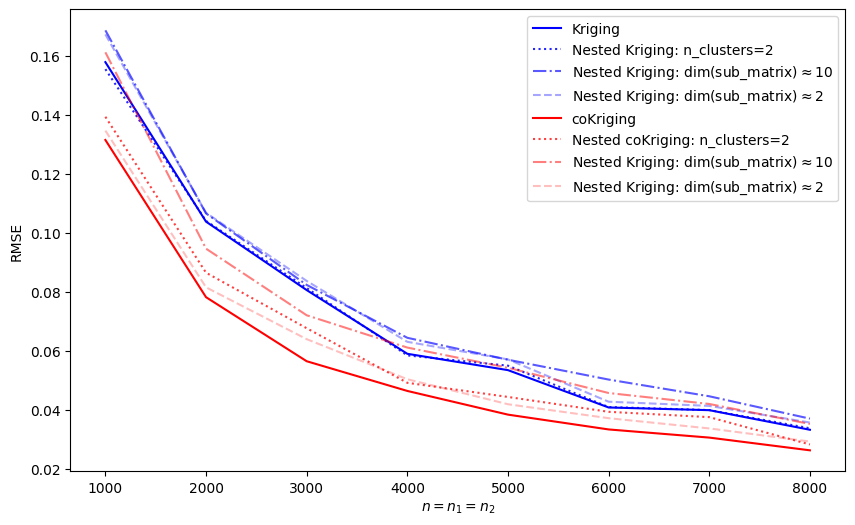

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_K, label='Kriging', c='b')
plt.plot(ns, RMSEs_NK[:, 0], label='Nested Kriging: n_clusters=2', ls=':', c='b', alpha=.85)
plt.plot(ns, RMSEs_NK[:, 1], label=r'Nested Kriging: dim(sub_matrix)$\approx$10', ls='-.', c='b', alpha=.65)
plt.plot(ns, RMSEs_NK[:, 2], label=r'Nested Kriging: dim(sub_matrix)$\approx$2', ls='--', c='b', alpha=.35)
    
plt.plot(ns, RMSEs_coK, label='coKriging', c='r')
plt.plot(ns, RMSEs_NcoK[:, 0], label='Nested coKriging: n_clusters=2', ls=':', c='r', alpha=.75)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'Nested Kriging: dim(sub_matrix)$\approx$10', ls='-.', c='r', alpha=.5)
plt.plot(ns, RMSEs_NcoK[:, 2], label=r'Nested Kriging: dim(sub_matrix)$\approx$2', ls='--', c='r', alpha=.25)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

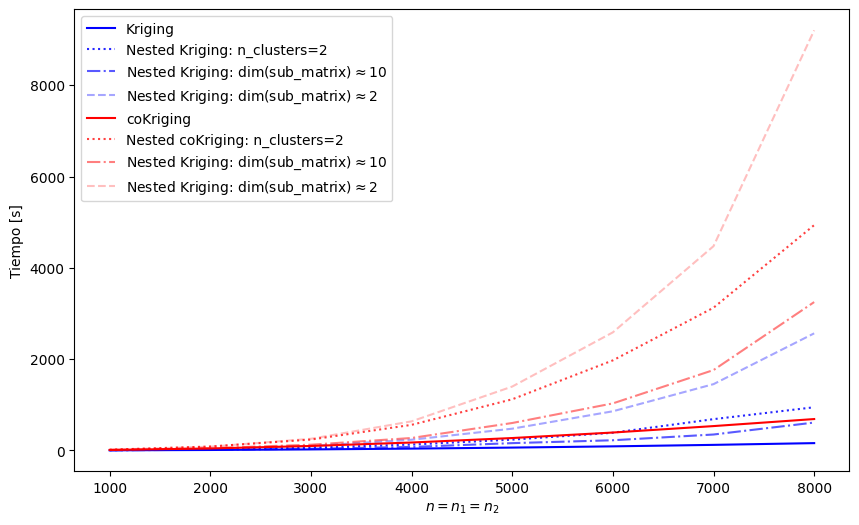

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_K, label='Kriging', c='b')
plt.plot(ns, times_NK[:, 0], label='Nested Kriging: n_clusters=2', ls=':', c='b', alpha=.85)
plt.plot(ns, times_NK[:, 1], label=r'Nested Kriging: dim(sub_matrix)$\approx$10', ls='-.', c='b', alpha=.65)
plt.plot(ns, times_NK[:, 2], label=r'Nested Kriging: dim(sub_matrix)$\approx$2', ls='--', c='b', alpha=.35)
    
plt.plot(ns, times_coK, label='coKriging', c='r')
plt.plot(ns, times_NcoK[:, 0], label='Nested coKriging: n_clusters=2', ls=':', c='r', alpha=.75)
plt.plot(ns, times_NcoK[:, 1], label=r'Nested Kriging: dim(sub_matrix)$\approx$10', ls='-.', c='r', alpha=.5)
plt.plot(ns, times_NcoK[:, 2], label=r'Nested Kriging: dim(sub_matrix)$\approx$2', ls='--', c='r', alpha=.25)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Tiempo [s]');

In [15]:
df = pd.DataFrame()

df['n'] = ns
df['RMSE_k'] = RMSEs_K
df[['RMSE_nk_ncluster2', 'RMSE_nk_dimsubmatrix10', 'RMSE_nk_dimsubmatrix2']] = RMSEs_NK
df['RMSE_cok'] = RMSEs_coK
df[['RMSE_ncok_2', 'RMSE_ncok_dimsubmatrix10', 'RMSE_ncok_dimsubmatrix2']] = RMSEs_NcoK


df['time_k'] = times_K
df[['time_nk_ncluster2', 'time_nk_dimsubmatrix10', 'time_nk_dimsubmatrix2']] = times_NK
df['time_cok'] = times_coK
df[['time_ncok_2', 'time_ncok_dimsubmatrix10', 'time_ncok_dimsubmatrix2']] = times_NcoK

df

,n,RMSE_k,RMSE_nk_ncluster2,RMSE_nk_dimsubmatrix10,RMSE_nk_dimsubmatrix2,RMSE_cok,RMSE_ncok_2,RMSE_ncok_dimsubmatrix10,RMSE_ncok_dimsubmatrix2,time_k,time_nk_ncluster2,time_nk_dimsubmatrix10,time_nk_dimsubmatrix2,time_cok,time_ncok_2,time_ncok_dimsubmatrix10,time_ncok_dimsubmatrix2
0,1000,0.158024,0.155640,0.168826,0.167451,0.131590,0.139468,0.161361,0.134771,2.547917,5.000046,3.472438,6.767020,10.797861,16.599902,11.560392,15.566694
1,2000,0.103852,0.104114,0.106649,0.106841,0.078201,0.086512,0.094678,0.081551,9.949724,23.865562,15.732848,32.330144,43.399804,86.134984,49.484314,81.633775
2,3000,0.080615,0.081315,0.082374,0.083727,0.056452,0.067665,0.072059,0.063946,22.366551,60.747769,36.313785,98.427805,97.683793,238.035991,125.704507,255.600527
3,4000,0.058977,0.058434,0.064409,0.063043,0.046362,0.049126,0.061092,0.050337,39.900109,128.415229,76.750500,234.601164,173.517437,560.688162,272.701376,637.286432
4,5000,0.053427,0.054950,0.056964,0.057070,0.038317,0.044323,0.054235,0.041846,62.450185,236.617509,159.917597,476.608270,271.751314,1120.540343,601.085146,1399.573854
5,6000,0.040747,0.040892,0.050226,0.042705,0.033288,0.039274,0.045657,0.037106,89.466909,387.517122,223.100627,857.987691,392.435412,1973.278126,1030.705009,2587.180234
6,7000,0.039830,0.039866,0.044551,0.041282,0.030520,0.037466,0.041937,0.033633,122.062533,685.459190,348.918683,1452.422888,533.515239,3126.402335,1761.024012,4474.955867
7,8000,0.033176,0.033684,0.036954,0.035630,0.026197,0.028181,0.035153,0.029178,160.167176,945.988315,610.936464,2565.304990,687.670353,4936.076489,3250.197462,9203.529892


In [16]:
df_aux = pd.read_csv(r'D:\Aleja\OneDrive - Universidad Técnica Federico Santa María\Material universidad\0 Tesís\n_vs_time_rmse.csv', sep=';')

df = pd.concat([df_aux, df], axis=0)

df.to_csv(r'D:\Aleja\OneDrive - Universidad Técnica Federico Santa María\Material universidad\0 Tesís\n_vs_time_rmse.csv', index=False, sep=';')